In [1]:
from concurrent.futures import ThreadPoolExecutor
from typing import List, Tuple
import colorsys
import numpy as np
import matplotlib.pyplot as plt
import sk_dsp_comm.sigsys as ss
from numpy.typing import NDArray
from scipy.signal import find_peaks
import matplotlib.colors as colors

NP1DF8 = NDArray[np.float64]
NP2DF8 = NDArray[np.float64]
NP1DC16 = NDArray[np.complex128]
NP2DC16 = NDArray[np.complex128]
TT_TYPE = NDArray[np.int64]

def filter_negWaveVectors(M_yx: NP2DC16) -> NP2DC16:
    M_kq = np.fft.fft2(M_yx)
    kLen = int(M_kq.shape[1] / 2 + 1)
    zeros = np.zeros((M_kq.shape[0], kLen))
    M_kq[:, :kLen] = zeros
    M_yx_filtered = np.fft.ifft2(M_kq)
    M_yx_filtered /= np.amax(
        np.abs(M_yx_filtered[:, int(M_yx_filtered.shape[1] / 2 + 100)])
    )
    return M_yx_filtered

def initialize_point_src() -> NP2DC16:
    M_oop = np.load("./point_source_yig/point_source_2600_MHz_200_mT_OOP.npz")["M"]
    pointSrc0 = filter_negWaveVectors(M_oop)
    return pointSrc0[:, int(pointSrc0.shape[1]/2) :]

def generate_rectangular_function(
    distance_between_inputs: int,
    unit_cell_size: int,
    number_of_inputs: int,
    input_width: int,
) -> Tuple[NP1DF8, NP1DF8, float]:
    d = distance_between_inputs / unit_cell_size
    s = input_width / unit_cell_size
    width = d * number_of_inputs
    x_int = np.arange(0, width, 1)
    rec = ss.rect(np.mod(x_int, d) - d/2, s)
    return rec, x_int, d

def calculate_analytic_signal(
    g_in: NP1DF8,
    x_int: NP1DF8,
    changed_src_numbers_left: List[int],
    changed_src_numbers_right: List[int],
    input_phase_shift: float,
    active_input_amplitude: float,
):
    g_in_an_left = np.zeros_like(x_int, dtype=complex)
    g_in_an_right = np.zeros_like(x_int, dtype=complex)
    b = 1
    for i in range(len(x_int)):
        if g_in[i] == 1 and (b in changed_src_numbers_left):
            phi_t = input_phase_shift
            Amp = active_input_amplitude
            if g_in[i + 1] == 0:
                b += 1
        elif g_in[i] == 1:
            phi_t = 0
            Amp = 1
            if g_in[i + 1] == 0:
                b += 1
        else:
            phi_t = 0
            Amp = 1
        g_in_an_left[i] = Amp * g_in[i] * np.exp(1j * phi_t)
        
    b = 1
    for i in range(len(x_int)):
        if g_in[i] == 1 and (b in changed_src_numbers_right):
            phi_t = input_phase_shift
            Amp = active_input_amplitude
            if g_in[i + 1] == 0:
                b += 1
        elif g_in[i] == 1:
            phi_t = 0
            Amp = 1
            if g_in[i + 1] == 0:
                b += 1
        else:
            phi_t = 0
            Amp = 1
        g_in_an_right[i] = Amp * g_in[i] * np.exp(1j * phi_t)
        
    return g_in_an_left, g_in_an_right

def convolve_column(pointSrc: NP2DC16, g_in: NP1DC16, i: int) -> NP1DC16:
    return np.convolve(pointSrc[:, i], g_in, mode="full")

def convolve_columns(pointSrc: NP2DC16, g_in: NP1DC16) -> NP2DC16:
    newField = np.empty(
        (pointSrc.shape[0] + g_in.shape[0] - 1, pointSrc.shape[1]), dtype=np.complex128
    )
    with ThreadPoolExecutor() as executor:
        futures = [
            executor.submit(convolve_column, pointSrc, g_in, i)
            for i in range(pointSrc.shape[1])
        ]
        for i, future in enumerate(futures):
            newField[:, i] = future.result()
    return newField

# def calculate_truth_table(
#     distance_between_inputs: float,
#     max_i: List[float], 
#     number_of_inputs: int,
#     input_width: int,
#     unite_cell_size: int
#     ) -> TT_TYPE:
#     truth_table = np.zeros(number_of_inputs-1)
#     for i in range(0, number_of_inputs-1):
#         if any((i+0.5)*distance_between_inputs + input_width/2
#                <= element*unite_cell_size <= 
#                (i+1.5)*distance_between_inputs - input_width/2 for element in max_i):
#             truth_table[i] = 1
#     return truth_table

def folding_field(arr_in, x_int):
    width = len(x_int)
    yShift = -2
    y0 = int(arr_in.shape[0]/2)
    nOfFolds = int(arr_in.shape[0]/width / 2)
    a_fld = arr_in[int(y0-0.5*width-yShift):int(y0+0.5*width-yShift),:]
    for i in range(1, nOfFolds):
        tmp = arr_in[int(y0+(i-0.5)*width-yShift):int(y0+(i+0.5)*width-yShift),:].copy()
        a_fld += tmp[::(-1)**abs(i),:]
        tmp = arr_in[int(y0+(-i-0.5)*width-yShift):int(y0+(-i+0.5)*width-yShift),:].copy()
        a_fld += tmp[::(-1)**abs(i),:]
    return a_fld[:,:]

def colourMode(mod, phase):
    mod = mod/np.amax(mod)
    array1 = np.zeros((phase.shape[0], phase.shape[1], 3))
    for y in range(phase.shape[0]):
        for x in range(phase.shape[1]):
            h = 0.5+phase[y,x]/(2*np.pi)  # angle
            l, s = (mod[y,x]), 1
            array1[y,x] = np.array(colorsys.hls_to_rgb(h, l, s))
    return array1

def visualize_intensity_chessboard(intensity, n):
    Nx, Ny = intensity.shape
    step_x = Nx // n
    step_y = Ny // n

    avg_intensity = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            row_start = i * step_x
            row_end   = (i + 1) * step_x
            col_start = j * step_y
            col_end   = (j + 1) * step_y
            
            row_end = min(row_end, Nx)
            col_end = min(col_end, Ny)
            
            cell_data = intensity[row_start:row_end, col_start:col_end]
            avg_intensity[i, j] = np.mean(cell_data)
            
    return avg_intensity, step_x, step_y

In [2]:
def logic_oop(
    number_of_inputs: int,
    distance_between_inputs: int,  # nm
    input_width: int,  # nm
    active_inputs_left: List[int],
    active_inputs_right: List[int],
    active_input_phase_shift: float,
    active_input_amplitude: float,
    wavelength: float,  # nm
    unit_cell_size: int,  # nm
    # offset: int,
    mid_line: int,
    w_axhl: int,
    x_size: int, #nm
    n_on_chessboard: int,
    plots: bool = True,
    folding: bool = False,
    chess_plots: bool = True,
):
    
    axhl = int(mid_line // unit_cell_size)
    x_size = int(x_size // unit_cell_size)

    pointSrc: NP2DC16 = initialize_point_src()

    g_in, x_int, d = generate_rectangular_function(
        distance_between_inputs,
        unit_cell_size,
        number_of_inputs,
        input_width,
    )

    g_in_c_left, g_in_c_right = calculate_analytic_signal(
        g_in,
        x_int,
        active_inputs_left,
        active_inputs_right,
        active_input_phase_shift,
        active_input_amplitude,
    )

    newField_left: NP2DC16 = convolve_columns(pointSrc, g_in_c_left)
    newField_right: NP2DC16 = convolve_columns(pointSrc, g_in_c_right)
    if folding:
        newField =  newField_left + np.flip(newField_right)
        newField = folding_field(newField, x_int)[:, : x_size]
    else:
        newField_left_sliced = newField_left[int(pointSrc.shape[0] / 2) : -int(pointSrc.shape[0] / 2), : x_size]
        newField_right_sliced = newField_right[int(pointSrc.shape[0] / 2) : -int(pointSrc.shape[0] / 2), : x_size]
        newField =  newField_left_sliced + np.flip(newField_right_sliced)
        
    intensity = np.real(newField)**2 + np.imag(newField)**2
    intensity /= np.amax(np.abs(intensity[:, 20:-20]))
    
    int_avg: NP1DF8 = np.mean(intensity[:, axhl - w_axhl : axhl + w_axhl], axis=1)
    threshold = 0.8*int_avg.max()
    # max_i: List[float] = find_peaks(int_avg, height=threshold)[0]

    # truth_table = calculate_truth_table(distance_between_inputs, max_i, number_of_inputs, input_width, unit_cell_size)
    
    chess_array, step_x, step_y = visualize_intensity_chessboard(intensity, n_on_chessboard)
    
    if plots:
        phase_2plot = np.angle(newField)
        mod_2plot = np.abs(newField)
        intentsity_1d_x = np.arange(0, intensity.shape[0], 1)
        int_avg = np.mean(intensity[:, axhl - w_axhl:axhl + w_axhl], axis=1)
        # phase_1d_x = np.arange(0, intensity.shape[0], 1)
        # phase_1d = phase_2plot[:, axhl]
        max_i = find_peaks(int_avg, height=threshold)[0]
        
        f0, ax = plt.subplots(1, 3, figsize=(12, 7), gridspec_kw={"width_ratios": [1, 3, 1]})

        ax[0].plot(np.abs(g_in_c_left), x_int*unit_cell_size, color='k')
        ax[0].fill_between( 0, np.abs(g_in_c_left), x_int*unit_cell_size, color='#CCCCCC')
        ax[0].set_xlim(-0.1, 1.1)
        ax[0].set_xlabel("Amplitude")
        ax[0].set_ylabel("y (nm)")
        ax[0].set_ylim(0, number_of_inputs*distance_between_inputs)
        ax0a = ax[0].twiny()
        ax0a.plot(np.angle(g_in_c_left) * 180 / np.pi, x_int*unit_cell_size, color='maroon', ls='-', lw=4)
        ax0a.tick_params(axis='x', labelcolor='maroon')
        ax0a.set_xlabel("Phase (°)", color='maroon')
        ax0a.set_xlim(-190, 190)
        ax0a.set_xticks(range(-180, 190, 90))
        
        ax[1].imshow(np.flipud(colourMode(mod_2plot, phase_2plot)), aspect='auto', interpolation='sinc', extent=[0, x_size*unit_cell_size, 0, len(intentsity_1d_x)*unit_cell_size])
        # ax[1].axis('off')
        ax[1].tick_params(left=False, labelleft=False)
        ax[1].spines['left'].set_visible(False)
        ax[1].set_xlabel("x (nm)")
        # ax[1].set_ylabel("y (nm)")
        
        ax[2].plot(np.abs(g_in_c_right), x_int[::-1]*unit_cell_size, color='k')
        ax[2].fill_between(0, np.abs(g_in_c_right), x_int[::-1]*unit_cell_size, color='#CCCCCC')
        ax[2].set_xlim(-0.1, 1.1)
        ax[2].set_xlabel("Amplitude")
        ax[2].tick_params(left=False, labelleft=False)
        ax[2].spines['left'].set_visible(False)
        ax[2].set_ylim(0, number_of_inputs*distance_between_inputs)
        ax0a = ax[2].twiny()
        ax0a.plot(np.angle(g_in_c_right) * 180 / np.pi, x_int[::-1]*unit_cell_size, color='maroon', ls='-', lw=4)
        ax0a.tick_params(axis='x', labelcolor='maroon')
        ax0a.set_xlabel("Phase (°)", color='maroon')
        ax0a.set_xlim(-190, 190)
        ax0a.set_xticks(range(-180, 190, 90))
        
        for i in range(number_of_inputs):
            ax[0].text(
                    1.03, 0.055+i*0.111, 
                    f"[{i+1}]", 
                    transform=ax[0].transAxes, 
                    ha="center", 
                    va="center", 
                    color="blue", 
                    fontweight="bold",
                    fontsize=15,
                    bbox=dict(facecolor="white",edgecolor="none",alpha=0.8),
                    zorder=10
                    )
            ax[2].text(
                    -0.04, 0.055+i*0.111, 
                    f"[{number_of_inputs-i}]", 
                    transform=ax[2].transAxes, 
                    ha="center", 
                    va="center", 
                    color="red", 
                    fontweight="bold",
                    fontsize=15,
                    bbox=dict(facecolor="white",edgecolor="none",alpha=0.8),
                    zorder=10
                    )
            
        #-------------------------------------------------------------------------------------------
        
        f1, ax1 = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={"height_ratios": [3, 1]})

        ax1[0].imshow(intensity, vmin=0, vmax=0.5, aspect='equal', extent=[0, x_size*unit_cell_size, 0, len(intentsity_1d_x)*unit_cell_size])
        ax1[0].axvline(axhl*unit_cell_size, color='red', lw=w_axhl, alpha=0.4)
        for i in range(1, n_on_chessboard):
            ax1[0].axhline(y=i * (step_x )*unit_cell_size, color='white', ls='--', lw=2)
        for j in range(1, n_on_chessboard):
            ax1[0].axvline(x=j * (step_y )*unit_cell_size, color='white', ls='--', lw=2)
        # ax[0].set_xlabel("x (nm)")
        # ax[0].set_ylabel("y (nm)")
        # for i in range(0, number_of_inputs):
        #     ax1[0].axhline(distance_between_inputs/unit_cell_size * ((i+0.5)*unit_cell_size), color='yellow', lw=2, alpha=0.4, xmin=0.2, xmax=0.5)
            
        ax1[1].set_ylim(0, threshold*1.5)
        ax1[1].plot(intentsity_1d_x*unit_cell_size, int_avg, linewidth=3, color='blue')
        # ax[1].set_ylabel("Amplitude")
        ax1[1].axhline(threshold, color='orange', ls='--')
        # for i in range(0, number_of_inputs-1):
        #     ax1[1].text(distance_between_inputs/unit_cell_size * (i+1)*unit_cell_size, 0.8, f"{int(truth_table[i])}", color='black', fontsize=12, ha='center')
        # for i in range(0, number_of_inputs):
        #     ax1[1].axhline(distance_between_inputs/unit_cell_size * (i+0.5)*unit_cell_size, color='orange', lw=2, alpha=0.4)
        # for j in max_i:
        #     ax1[1].scatter(int_avg[j], j*unit_cell_size, zorder=3, color='red')
        plt.tight_layout()
        plt.show()
        
    if chess_plots:
        plt.figure(figsize=(5, 4))
        # Use 'origin=lower' to keep (0,0) at bottom-left
        chess = plt.imshow(chess_array, cmap='inferno', origin='lower', interpolation='nearest')
        plt.colorbar(label="Avg. Intensity")
        plt.title("Averaged n×n chessboard")
        plt.xlabel("Cell index (X)")
        plt.ylabel("Cell index (Y)")

        plt.tight_layout()
        plt.show()

    return chess_array

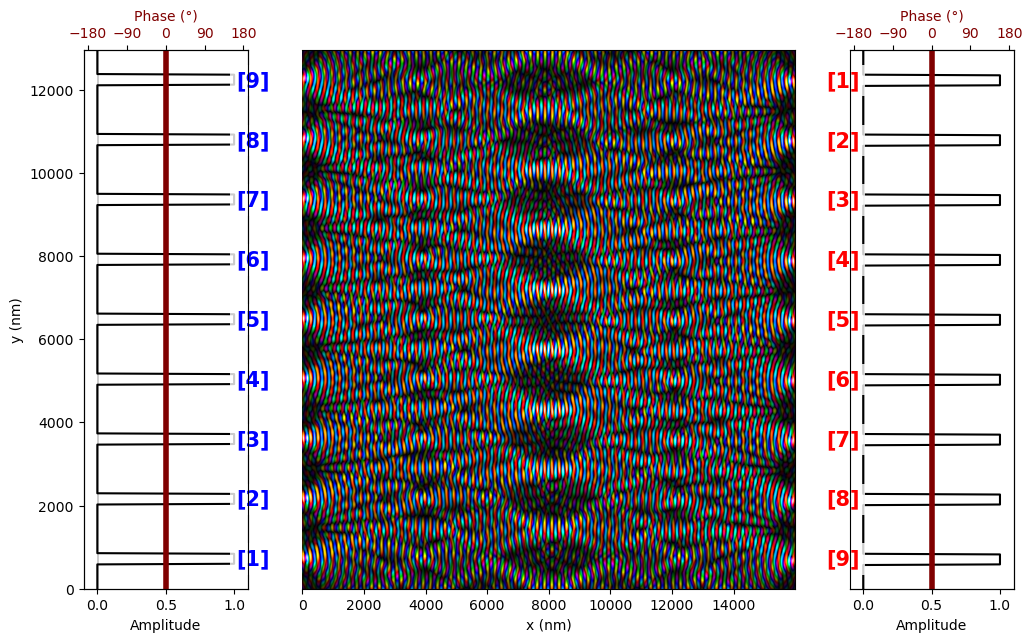

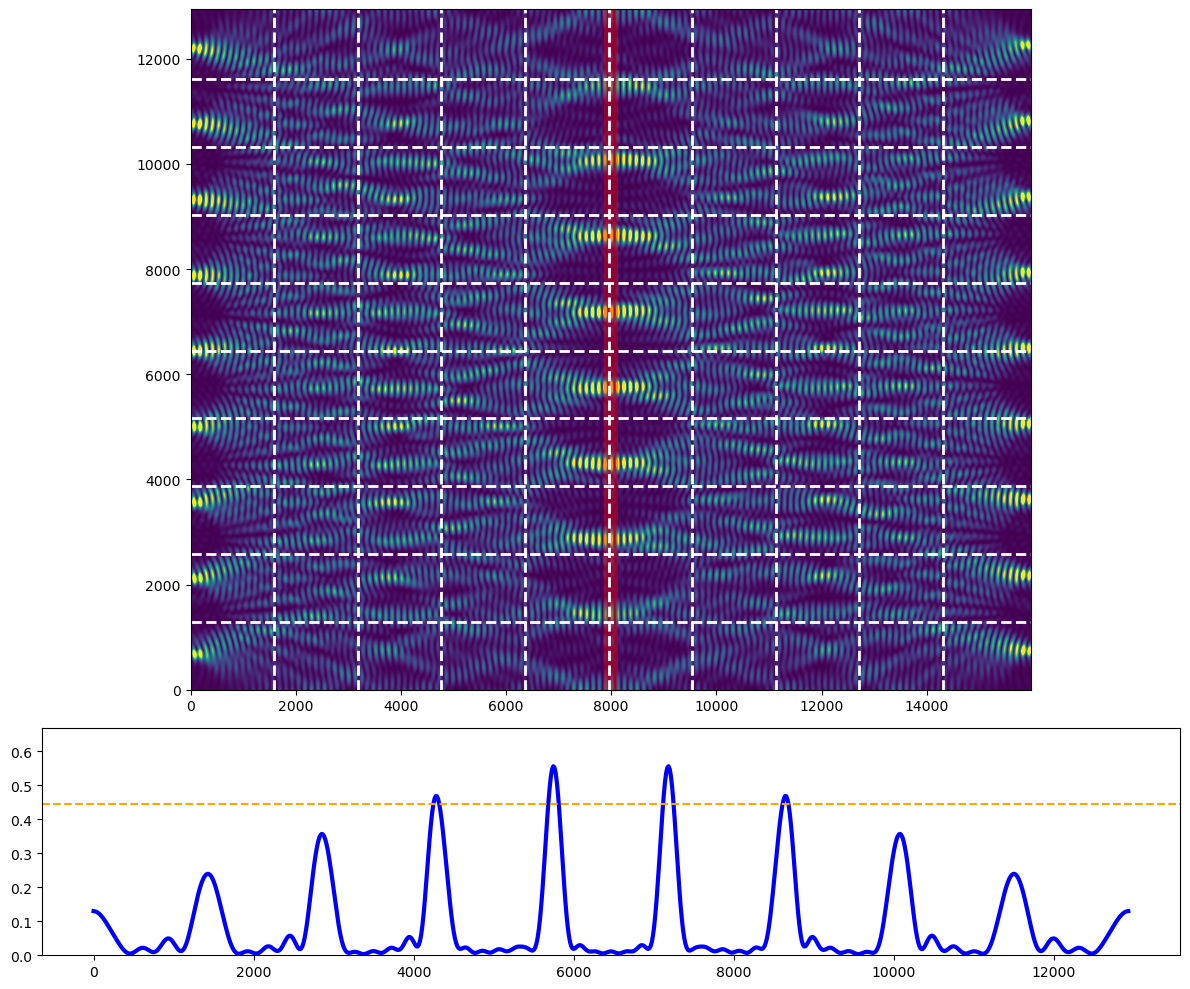

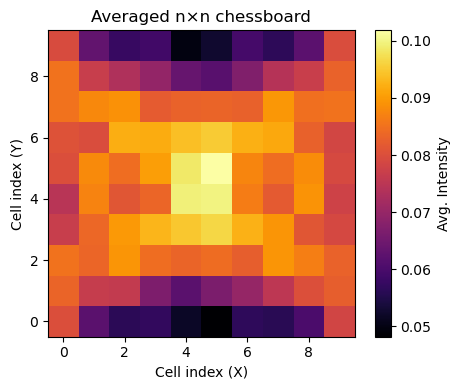

In [32]:
if __name__ == "__main__":
    tt = logic_oop(
        number_of_inputs=9,
        distance_between_inputs=1440,  # nm
        input_width=240,  # nm
        active_inputs_left=[],
        active_inputs_right=[],
        active_input_phase_shift=np.pi/2,
        active_input_amplitude= 1,  # 1 -> unchanged
        wavelength=232,  # nm
        unit_cell_size=15,  # nm
        mid_line=8000,  # nm
        w_axhl=10,
        x_size=16000, #nm
        n_on_chessboard=10,
        plots=True,
        folding=False,
        chess_plots=True
        )

In [ ]:
def run_logic_gate_simulation():
    # Define a threshold value for determining logical '1' (this may need calibration)
    threshold_value = 0.5  
    truth_table = {}
    
    number_of_inputs=9
    distance_between_inputs=1440 # nm
    input_width=240  # nm
    active_input_phase_shift=np.pi/2
    active_input_amplitude= 1  # 1 -> unchanged
    wavelength=232  # nm
    unit_cell_size=15  # nm
    mid_line=8000  # nm
    w_axhl=10
    x_size=16000 #nm
    n_on_chessboard=10
    plots=False
    folding=False
    chess_plots=True
    
    # For a two-input gate, iterate over all combinations: (0,0), (0,1), (1,0), (1,1)
    for left_input in [0, 1]:
        for right_input in [0, 1]:
            active_inputs_left = [4] if left_input == 1 else []
            active_inputs_right = [4] if right_input == 1 else []
            
            intensity_matrix = logic_oop(
                number_of_inputs,
                distance_between_inputs,  # nm
                input_width,  # nm
                active_inputs_left,
                active_inputs_right,
                active_input_phase_shift,
                active_input_amplitude,  # 1 -> unchanged
                wavelength,  # nm
                unit_cell_size,  # nm
                mid_line,  # nm
                w_axhl,
                x_size, #nm
                n_on_chessboard,
                plots,
                folding,
                chess_plots
                )

            logic_matrix = threshold_intensity(intensity_matrix, threshold_value)
            
            # center cell as the output indicator.
            center_index = logic_matrix.shape[0] // 2
            output_bit = logic_matrix[center_index, center_index]
            
            # Store and print the result.
            truth_table[(left_input, right_input)] = output_bit
            print(f"Inputs L: {left_input}, R: {right_input} -> Output: {output_bit}")
    
    return truth_table

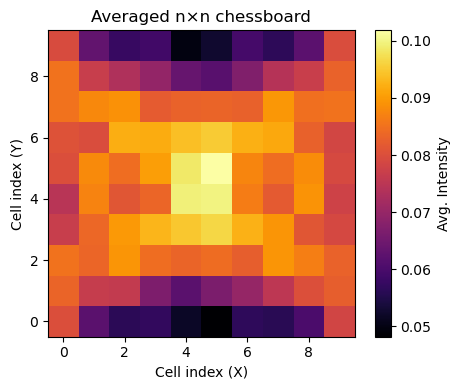

Inputs L: 0, R: 0 -> Output: 1


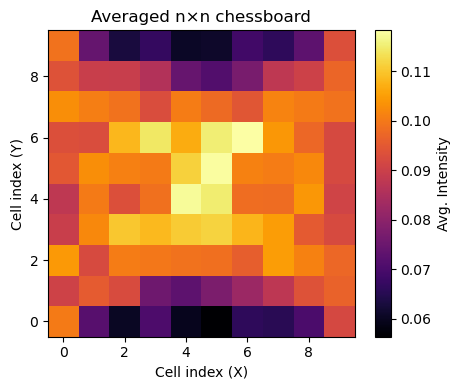

Inputs L: 0, R: 1 -> Output: 1


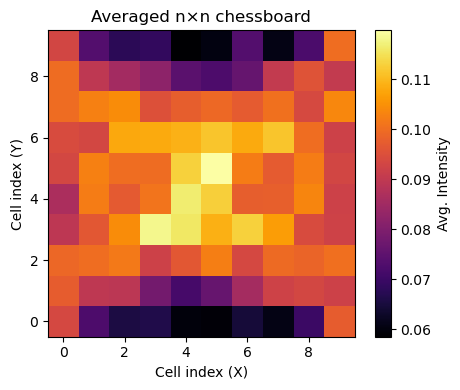

Inputs L: 1, R: 0 -> Output: 1


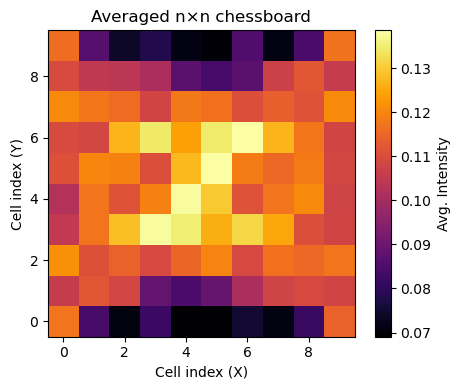

Inputs L: 1, R: 1 -> Output: 1


{(0, 0): 1, (0, 1): 1, (1, 0): 1, (1, 1): 1}

In [36]:
run_logic_gate_simulation()

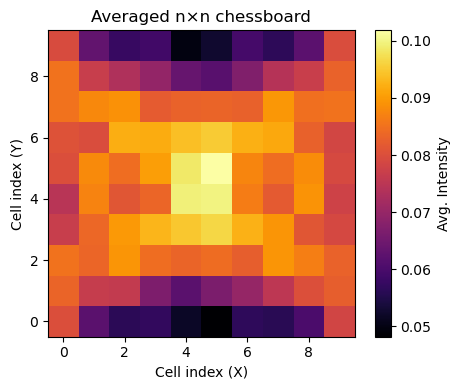

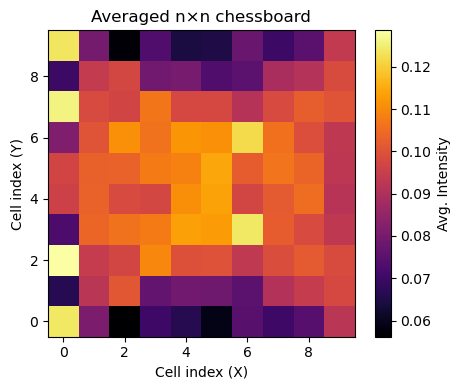

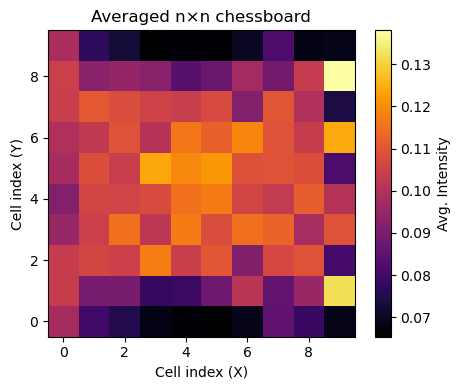

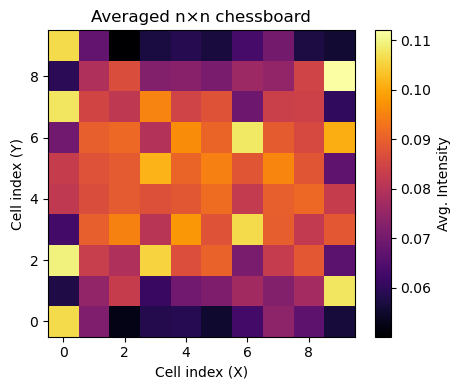

Best output cell found at: (0, 7)
Threshold selected: 0.31
Inputs (0, 0) -> Output at cell (0, 7): 0
Inputs (0, 1) -> Output at cell (0, 7): 0
Inputs (1, 0) -> Output at cell (0, 7): 1
Inputs (1, 1) -> Output at cell (0, 7): 1
Generated Truth Table: {(0, 0): 0, (0, 1): 0, (1, 0): 1, (1, 1): 1}


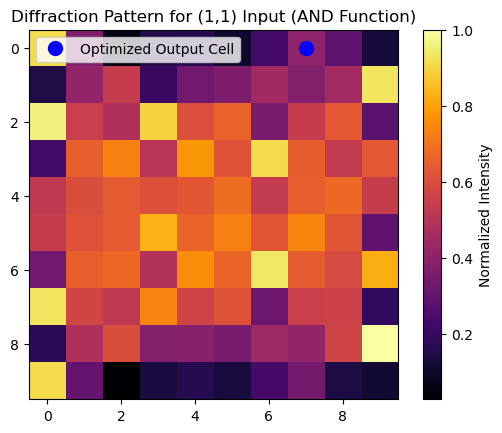

In [7]:
def get_truth_table(logic_function):
    logic_function = logic_function.lower()
    if logic_function == 'and':
        return {(0, 0): 0, (0, 1): 0, (1, 0): 0, (1, 1): 1}
    elif logic_function == 'or':
        return {(0, 0): 0, (0, 1): 1, (1, 0): 1, (1, 1): 1}
    elif logic_function == 'xor':
        return {(0, 0): 0, (0, 1): 1, (1, 0): 1, (1, 1): 0}
    else:
        raise ValueError("unsupported logic function! choose AND, OR, or XOR")

def find_best_output_cell_for_logic(desired_truth_table):
    """
    Simulates the diffraction pattern for all four input combinations, subtracts a common background,
    normalizes the results, and scans the chessboard grid to find the cell that best matches the desired truth table.
    The error is measured as the sum of squared differences between the normalized intensity and desired value.
    """
    combinations = [(0, 0), (0, 1), (1, 0), (1, 1)]
    simulation_results = {}
    
    number_of_inputs=9
    distance_between_inputs=1440 # nm
    input_width=240  # nm
    active_input_phase_shift=np.pi/2
    active_input_amplitude= 1  # 1 -> unchanged
    wavelength=232  # nm
    unit_cell_size=15  # nm
    mid_line=8000  # nm
    w_axhl=10
    x_size=16000 #nm
    n_on_chessboard=10
    plots=False
    folding=False
    chess_plots=True
    
    # Simulate for each input configuration.
    for left, right in combinations:
        active_inputs_left = [1,3,5,7,9] if left == 1 else []
        active_inputs_right = [0,2,4,6,8] if right == 1 else []
        intensity_matrix = logic_oop(
            number_of_inputs,
            distance_between_inputs,  # nm
            input_width,  # nm
            active_inputs_left,
            active_inputs_right,
            active_input_phase_shift,
            active_input_amplitude,  # 1 -> unchanged
            wavelength,  # nm
            unit_cell_size,  # nm
            mid_line,  # nm
            w_axhl,
            x_size, #nm
            n_on_chessboard,
            plots,
            folding,
            chess_plots
            )
        simulation_results[(left, right)] = intensity_matrix

    # Use the (0,0) configuration to help subtract the background.
    background = np.min(simulation_results[(0, 0)])
    
    # Subtract background and normalize each simulation result.
    for key in simulation_results:
        intensity = simulation_results[key]
        intensity_corrected = intensity - background
        intensity_corrected = np.maximum(intensity_corrected, 0)
        simulation_results[key] = intensity_corrected / np.max(intensity_corrected)
    
    best_cell = None
    best_error = float('inf')
    n_rows, n_cols = simulation_results[(0, 0)].shape

    # Evaluate every cell by summing squared errors over all four input configurations.
    for i in range(n_rows):
        for j in range(n_cols):
            total_error = 0.0
            for combo in combinations:
                value = simulation_results[combo][i, j]
                desired = desired_truth_table[combo]  # 0 or 1
                total_error += (value - desired)**2
            if total_error < best_error:
                best_error = total_error
                best_cell = (i, j)
    return best_cell, simulation_results

def verify_and_adjust_threshold(simulation_results, best_cell, desired_truth_table,
                                candidate_thresholds):
    """
    Iterates over candidate thresholds to verify if the output at best_cell matches the desired truth table.
    Returns the threshold that minimizes mismatches and the corresponding mismatch count.
    If an exact match is found (mismatch = 0), that threshold is returned.
    """
    best_threshold = None
    best_mismatch = float('inf')
    for th in candidate_thresholds:
        mismatch = 0
        for combo, matrix in simulation_results.items():
            output = 1 if matrix[best_cell] > th else 0
            if output != desired_truth_table[combo]:
                mismatch += 1
        if mismatch == 0:
            return th, 0
        if mismatch < best_mismatch:
            best_mismatch = mismatch
            best_threshold = th
    return best_threshold, best_mismatch

def run_logic_gate_simulation_for_logic(logic_function):
    """
    Runs the simulation for the chosen logic function, finds the optimal output cell,
    verifies and adjusts the threshold until the desired truth table is met (or nearly met),
    and prints the resulting truth table.
    """
    desired_truth_table = get_truth_table(logic_function)
    best_cell, simulation_results = find_best_output_cell_for_logic(desired_truth_table)
    print("Best output cell found at:", best_cell)
    
    # Verify and adjust threshold.
    candidate_thresholds = np.linspace(0.1, 0.9, 20)
    threshold_value, mismatch_count = verify_and_adjust_threshold(simulation_results, best_cell,
                                                                  desired_truth_table, candidate_thresholds)
    print(f"Threshold selected: {threshold_value:.2f}")
    if mismatch_count != 0:
        print(f"Warning: The desired truth table was not exactly achieved. Mismatch count: {mismatch_count}")
    
    truth_table = {}
    for inputs, norm_intensity_matrix in simulation_results.items():
        logic_value = 1 if norm_intensity_matrix[best_cell] > threshold_value else 0
        truth_table[inputs] = logic_value
        print(f"Inputs {inputs} -> Output at cell {best_cell}: {logic_value}")
    
    return truth_table, best_cell, simulation_results, threshold_value, mismatch_count

if __name__ == "__main__":
    # Let the user choose the logic function.
    logic_function = input("Enter logic function (AND, OR, XOR): ")
    truth_table, best_cell, simulation_results, threshold_value, mismatch_count = run_logic_gate_simulation_for_logic(logic_function)
    print("Generated Truth Table:", truth_table)
    
    # Visualize an example diffraction pattern (e.g., for the (1,1) input configuration).
    example_intensity = simulation_results[(1, 1)]
    plt.imshow(example_intensity, cmap='inferno')
    plt.title(f"Diffraction Pattern for (1,1) Input ({logic_function.upper()} Function)")
    plt.colorbar(label="Normalized Intensity")
    # Mark the selected output cell.
    plt.plot(best_cell[1], best_cell[0], 'bo', markersize=10, label='Optimized Output Cell')
    plt.legend()
    plt.show()

Trying left inputs: [1, 3, 5, 7, 9] and right inputs: [0, 2, 4, 6, 8]


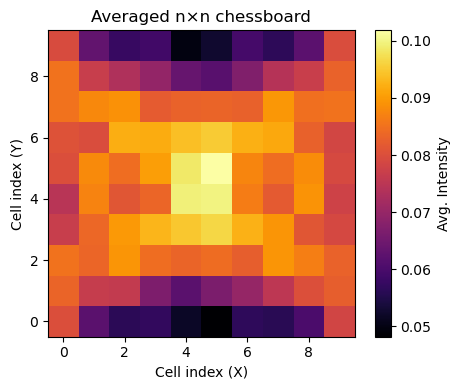

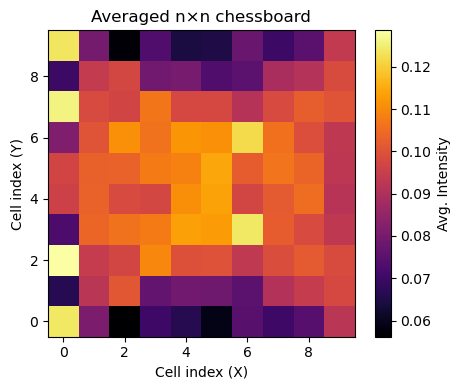

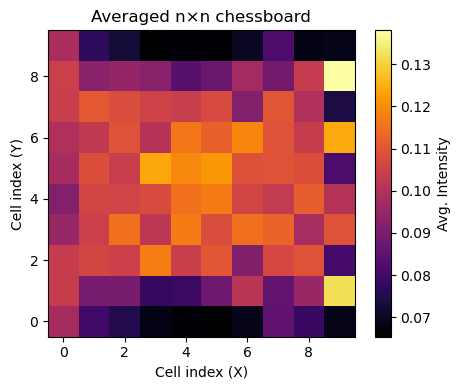

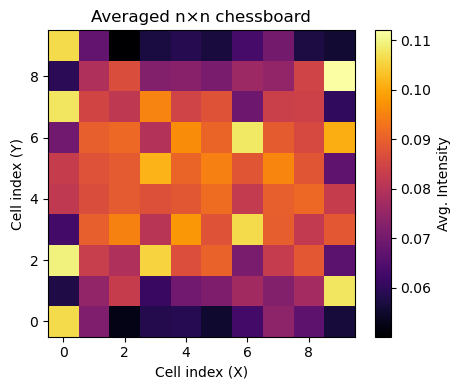

  With threshold 0.31, mismatch count = 1
Trying left inputs: [1, 3, 5, 7, 9] and right inputs: [0, 4, 8]


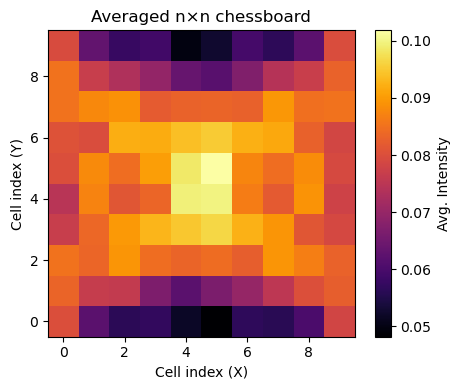

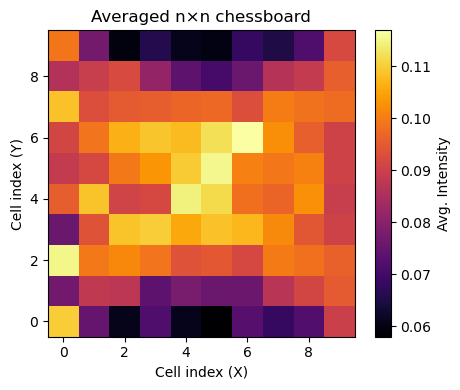

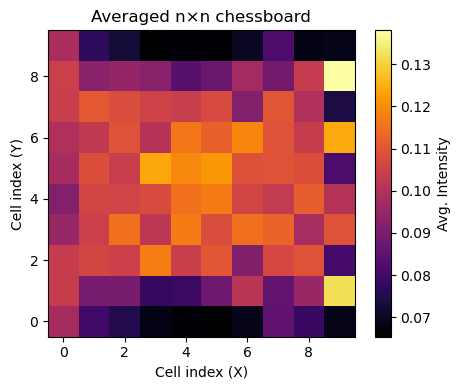

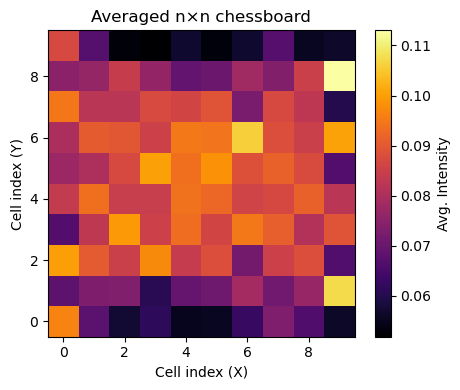

  With threshold 0.31, mismatch count = 1
Trying left inputs: [1, 3, 5, 7, 9] and right inputs: [2, 6]


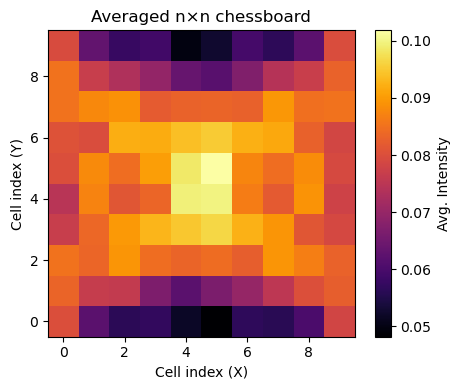

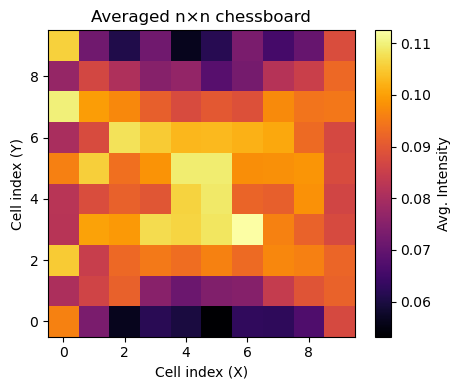

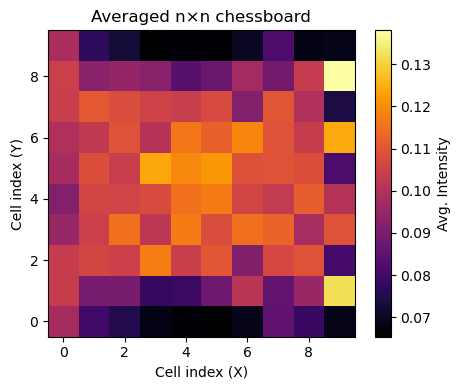

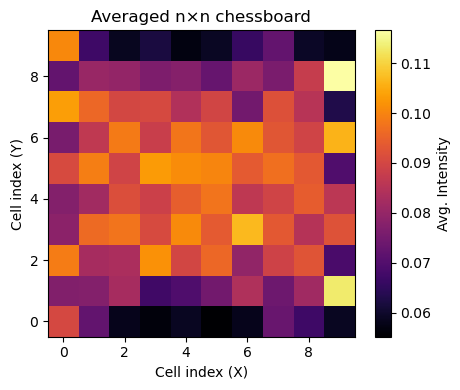

  With threshold 0.23, mismatch count = 1
Trying left inputs: [1, 3, 5, 7, 9] and right inputs: [0, 2, 4]


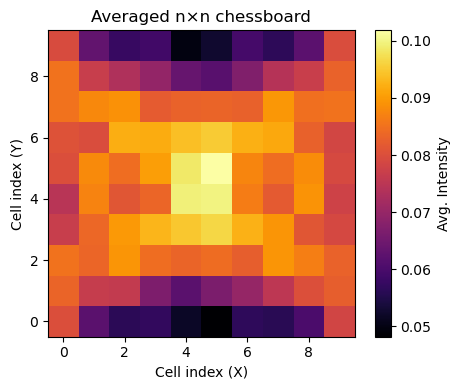

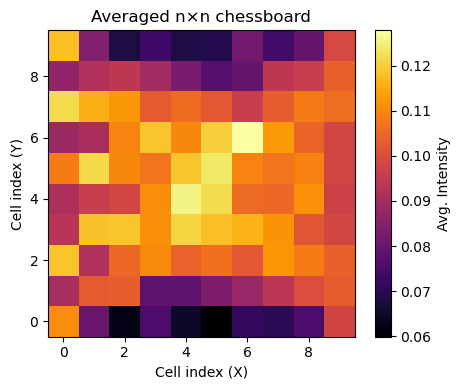

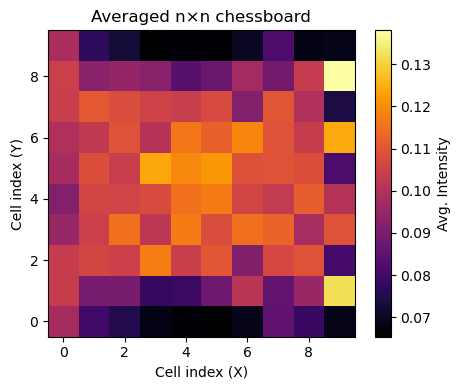

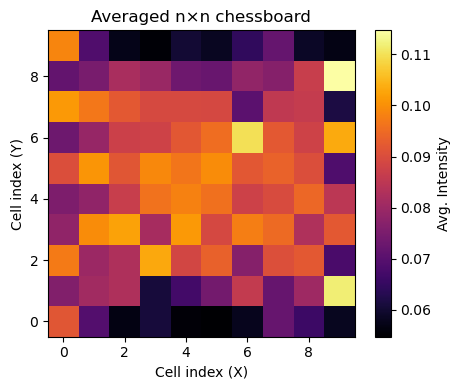

  With threshold 0.31, mismatch count = 1
Trying left inputs: [1, 3, 5, 7, 9] and right inputs: [4, 6, 8]


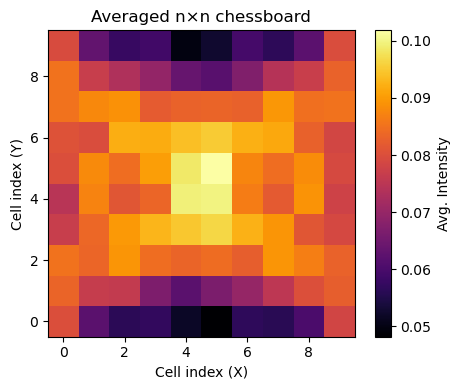

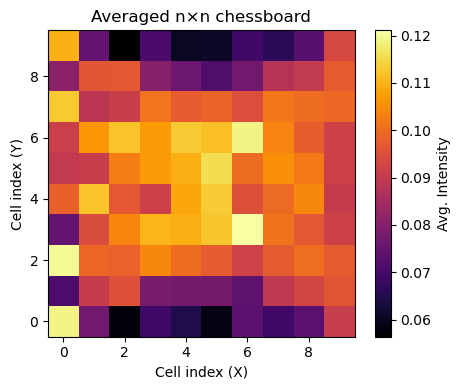

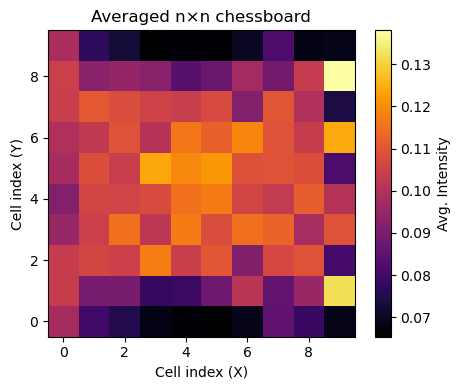

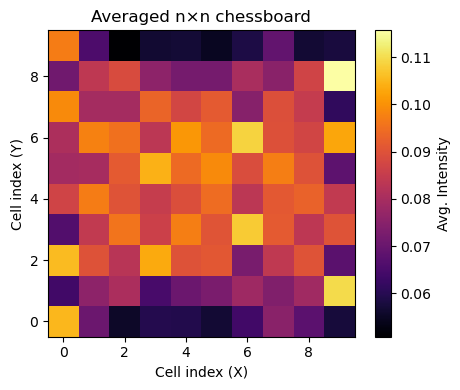

  With threshold 0.31, mismatch count = 1
Trying left inputs: [1, 5, 9] and right inputs: [0, 2, 4, 6, 8]


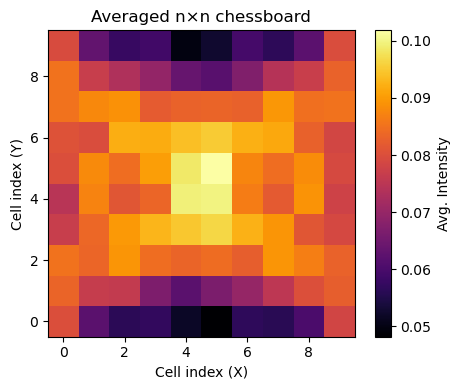

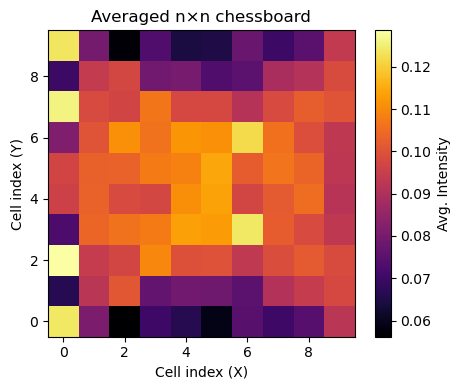

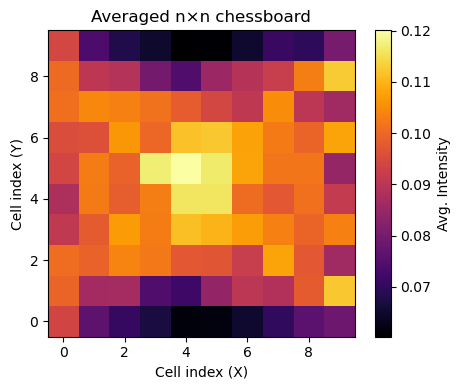

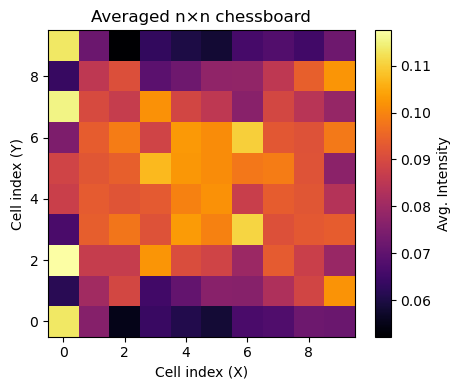

  With threshold 0.31, mismatch count = 1
Trying left inputs: [1, 5, 9] and right inputs: [0, 4, 8]


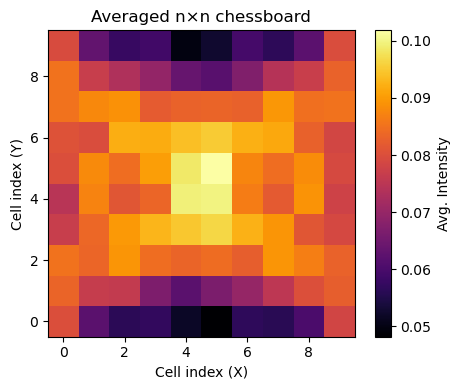

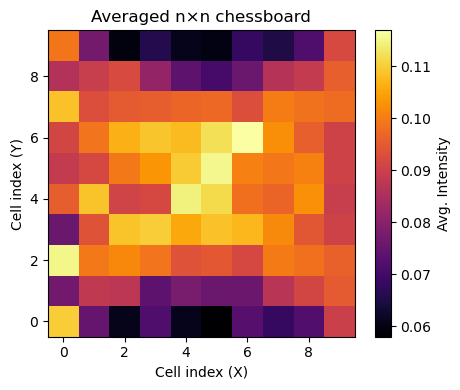

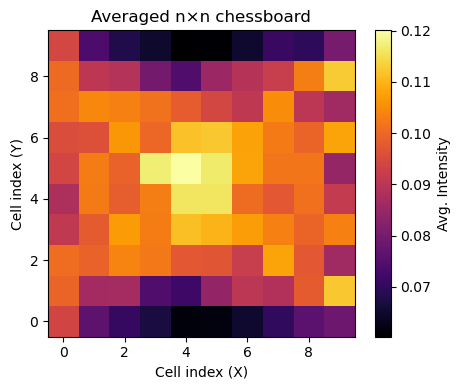

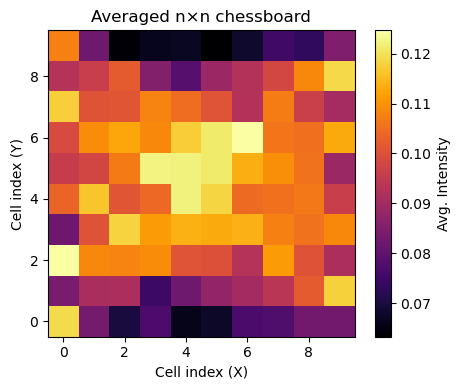

  With threshold 0.31, mismatch count = 0
Found configuration with zero mismatches!
Final chosen parameters:
  Left active inputs: [1, 5, 9]
  Right active inputs: [0, 4, 8]
  Best output cell: (0, 7)
  Threshold selected: 0.31052631578947365
Inputs (0, 0) -> Output at cell (0, 7): 0
Inputs (0, 1) -> Output at cell (0, 7): 0
Inputs (1, 0) -> Output at cell (0, 7): 0
Inputs (1, 1) -> Output at cell (0, 7): 1
Generated Truth Table: {(0, 0): 0, (0, 1): 0, (1, 0): 0, (1, 1): 1}


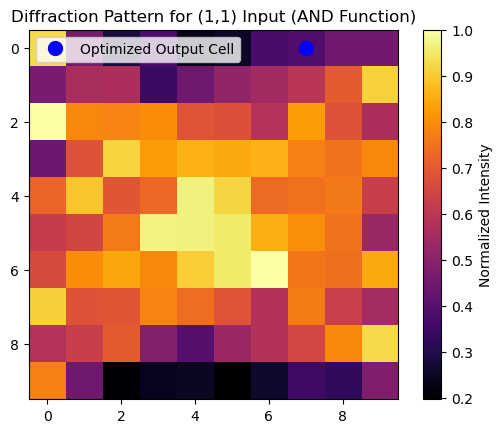

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def get_truth_table(logic_function):
    logic_function = logic_function.lower()
    if logic_function == 'and':
        return {(0, 0): 0, (0, 1): 0, (1, 0): 0, (1, 1): 1}
    elif logic_function == 'or':
        return {(0, 0): 0, (0, 1): 1, (1, 0): 1, (1, 1): 1}
    elif logic_function == 'xor':
        return {(0, 0): 0, (0, 1): 1, (1, 0): 1, (1, 1): 0}
    else:
        raise ValueError("Unsupported logic function! Choose AND, OR, or XOR")

def find_best_output_cell_for_logic(desired_truth_table, left_active, right_active):
    """
    Simulates the diffraction pattern for all four input combinations using the provided active input patterns,
    subtracts a background, normalizes the results, and scans the chessboard grid to find the cell that best matches
    the desired truth table. The error is measured as the sum of squared differences.
    """
    combinations = [(0, 0), (0, 1), (1, 0), (1, 1)]
    simulation_results = {}
    
    # Fixed simulation parameters.
    number_of_inputs = 9
    distance_between_inputs = 1440  # nm
    input_width = 240               # nm
    active_input_phase_shift = np.pi/2
    active_input_amplitude = 1      # unchanged
    wavelength = 232                # nm
    unit_cell_size = 15             # nm
    mid_line = 8000                 # nm
    w_axhl = 10
    x_size = 16000                  # nm
    n_on_chessboard = 10
    plots = False
    folding = False
    chess_plots = True

    # Simulate for each input combination.
    for left, right in combinations:
        # For each configuration, if the input is 1 use the candidate active pattern; otherwise, use an empty list.
        active_inputs_left = left_active if left == 1 else []
        active_inputs_right = right_active if right == 1 else []
        intensity_matrix = logic_oop(
            number_of_inputs,
            distance_between_inputs,  # nm
            input_width,  # nm
            active_inputs_left,
            active_inputs_right,
            active_input_phase_shift,
            active_input_amplitude,  # 1 -> unchanged
            wavelength,  # nm
            unit_cell_size,  # nm
            mid_line,  # nm
            w_axhl,
            x_size, #nm
            n_on_chessboard,
            plots,
            folding,
            chess_plots
            )
        simulation_results[(left, right)] = intensity_matrix

    # Use the (0,0) configuration to subtract a common background.
    background = np.min(simulation_results[(0, 0)])
    
    # Subtract background and normalize each simulation result.
    for key in simulation_results:
        intensity = simulation_results[key]
        intensity_corrected = intensity - background
        intensity_corrected = np.maximum(intensity_corrected, 0)
        simulation_results[key] = intensity_corrected / np.max(intensity_corrected)
    
    best_cell = None
    best_error = float('inf')
    n_rows, n_cols = simulation_results[(0, 0)].shape

    # Scan over all cells and compute the sum of squared errors relative to the desired truth table.
    for i in range(n_rows):
        for j in range(n_cols):
            total_error = 0.0
            for combo in combinations:
                value = simulation_results[combo][i, j]
                desired = desired_truth_table[combo]  # 0 or 1
                total_error += (value - desired)**2
            if total_error < best_error:
                best_error = total_error
                best_cell = (i, j)
    return best_cell, simulation_results

def verify_and_adjust_threshold(simulation_results, best_cell, desired_truth_table,
                                candidate_thresholds):
    """
    Iterates over candidate thresholds to check whether the output at best_cell matches the desired truth table.
    Returns the threshold that minimizes mismatches along with the mismatch count.
    """
    best_threshold = None
    best_mismatch = float('inf')
    for th in candidate_thresholds:
        mismatch = 0
        for combo, matrix in simulation_results.items():
            output = 1 if matrix[best_cell] > th else 0
            if output != desired_truth_table[combo]:
                mismatch += 1
        if mismatch == 0:
            return th, 0
        if mismatch < best_mismatch:
            best_mismatch = mismatch
            best_threshold = th
    return best_threshold, best_mismatch

def run_logic_gate_simulation_for_logic(logic_function):
    """
    Runs the simulation for the chosen logic function. It cycles through candidate active input combinations and thresholds,
    and returns the configuration (active inputs for left/right and threshold) that exactly reproduces the desired truth table.
    If no configuration gives an exact match, it returns the best candidate.
    """
    desired_truth_table = get_truth_table(logic_function)
    candidate_thresholds = np.linspace(0.1, 0.9, 20)
    
    # Define candidate active input combinations.
    candidate_active_inputs_left = [
        [1, 3, 5, 7, 9],
        [1, 5, 9],
        [3, 7],
        [1, 3, 5],
        [3, 5, 7]
    ]
    candidate_active_inputs_right = [
        [0, 2, 4, 6, 8],
        [0, 4, 8],
        [2, 6],
        [0, 2, 4],
        [4, 6, 8]
    ]
    
    best_configuration = None
    best_overall_mismatch = float('inf')
    
    # Try all candidate combinations.
    for left_active in candidate_active_inputs_left:
        for right_active in candidate_active_inputs_right:
            print(f"Trying left inputs: {left_active} and right inputs: {right_active}")
            best_cell, simulation_results = find_best_output_cell_for_logic(desired_truth_table, left_active, right_active)
            threshold_value, mismatch_count = verify_and_adjust_threshold(simulation_results, best_cell,
                                                                          desired_truth_table, candidate_thresholds)
            print(f"  With threshold {threshold_value:.2f}, mismatch count = {mismatch_count}")
            if mismatch_count == 0:
                print("Found configuration with zero mismatches!")
                best_configuration = {
                    'left_active': left_active,
                    'right_active': right_active,
                    'threshold': threshold_value,
                    'best_cell': best_cell,
                    'simulation_results': simulation_results,
                    'mismatch_count': mismatch_count
                }
                # Return immediately if an exact match is found.
                break
            elif mismatch_count < best_overall_mismatch:
                best_overall_mismatch = mismatch_count
                best_configuration = {
                    'left_active': left_active,
                    'right_active': right_active,
                    'threshold': threshold_value,
                    'best_cell': best_cell,
                    'simulation_results': simulation_results,
                    'mismatch_count': mismatch_count
                }
        if best_configuration is not None and best_configuration['mismatch_count'] == 0:
            break

    # Report the found configuration.
    print("Final chosen parameters:")
    print("  Left active inputs:", best_configuration['left_active'])
    print("  Right active inputs:", best_configuration['right_active'])
    print("  Best output cell:", best_configuration['best_cell'])
    print("  Threshold selected:", best_configuration['threshold'])
    if best_configuration['mismatch_count'] != 0:
        print(f"Warning: The desired truth table was not exactly achieved (mismatch count = {best_configuration['mismatch_count']}).")
    
    # Generate the truth table.
    truth_table = {}
    for inputs, norm_intensity_matrix in best_configuration['simulation_results'].items():
        logic_value = 1 if norm_intensity_matrix[best_configuration['best_cell']] > best_configuration['threshold'] else 0
        truth_table[inputs] = logic_value
        print(f"Inputs {inputs} -> Output at cell {best_configuration['best_cell']}: {logic_value}")
    
    return truth_table, best_configuration

if __name__ == "__main__":
    # Let the user choose the logic function.
    logic_function = input("Enter logic function (AND, OR, XOR): ")
    truth_table, config = run_logic_gate_simulation_for_logic(logic_function)
    print("Generated Truth Table:", truth_table)
    
    # Visualize an example diffraction pattern (using the (1,1) input configuration).
    example_intensity = config['simulation_results'][(1, 1)]
    plt.imshow(example_intensity, cmap='inferno')
    plt.title(f"Diffraction Pattern for (1,1) Input ({logic_function.upper()} Function)")
    plt.colorbar(label="Normalized Intensity")
    # Mark the selected output cell.
    plt.plot(config['best_cell'][1], config['best_cell'][0], 'bo', markersize=10, label='Optimized Output Cell')
    plt.legend()
    plt.show()

Trying left inputs: [1, 3, 5, 7, 9] and right inputs: [0, 2, 4, 6, 8]
  With threshold 0.31, mismatch count = 1
Trying left inputs: [1, 3, 5, 7, 9] and right inputs: [0, 4, 8]
  With threshold 0.31, mismatch count = 1
Trying left inputs: [1, 3, 5, 7, 9] and right inputs: [2, 6]
  With threshold 0.23, mismatch count = 1
Trying left inputs: [1, 3, 5, 7, 9] and right inputs: [0, 2, 4]
  With threshold 0.31, mismatch count = 1
Trying left inputs: [1, 3, 5, 7, 9] and right inputs: [4, 6, 8]
  With threshold 0.31, mismatch count = 1
Trying left inputs: [1, 5, 9] and right inputs: [0, 2, 4, 6, 8]
  With threshold 0.31, mismatch count = 1
Trying left inputs: [1, 5, 9] and right inputs: [0, 4, 8]
  With threshold 0.31, mismatch count = 0
Found configuration with zero mismatches!
Final chosen parameters:
  Left active inputs: [1, 5, 9]
  Right active inputs: [0, 4, 8]
  Best output cell: (0, 7)
  Threshold selected: 0.31052631578947365
Inputs (0, 0) -> Output at cell (0, 7): 0
Inputs (0, 1) -> O

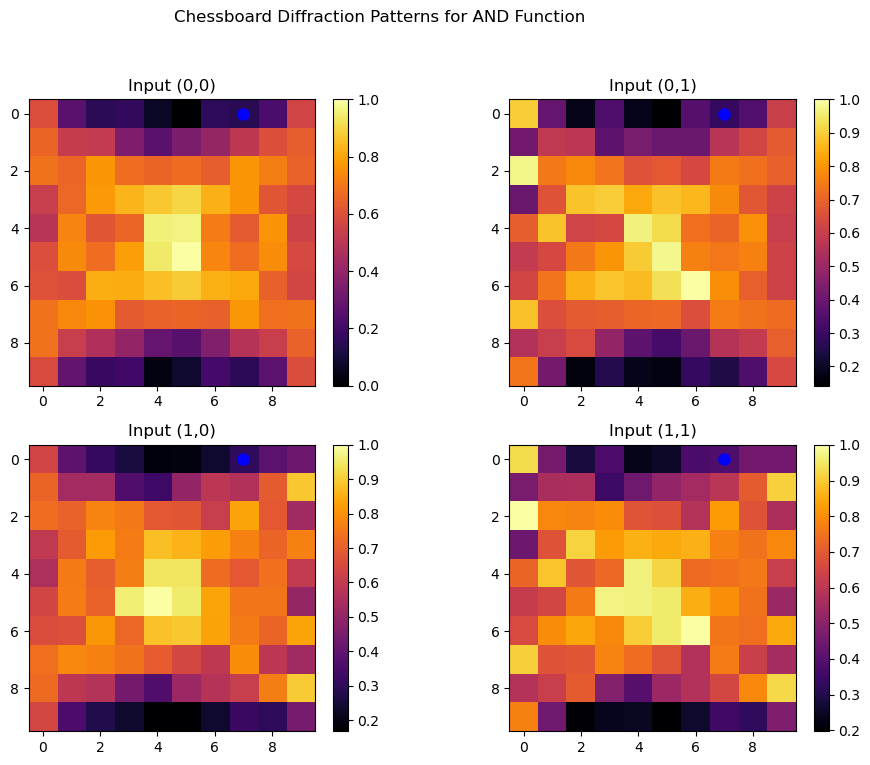

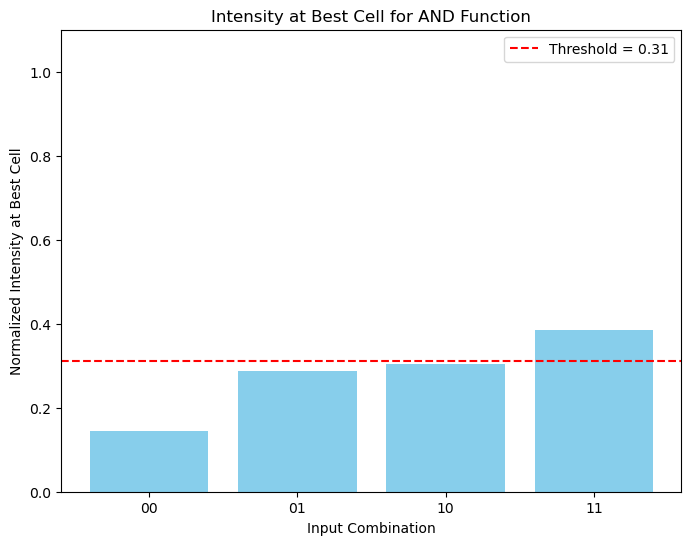

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def get_truth_table(logic_function):
    logic_function = logic_function.lower()
    if logic_function == 'and':
        return {(0, 0): 0, (0, 1): 0, (1, 0): 0, (1, 1): 1}
    elif logic_function == 'or':
        return {(0, 0): 0, (0, 1): 1, (1, 0): 1, (1, 1): 1}
    elif logic_function == 'xor':
        return {(0, 0): 0, (0, 1): 1, (1, 0): 1, (1, 1): 0}
    else:
        raise ValueError("Unsupported logic function! Choose AND, OR, or XOR")

def find_best_output_cell_for_logic(desired_truth_table, left_active, right_active):
    """
    Simulates the diffraction pattern for all four input combinations using the provided active input patterns,
    subtracts a background, normalizes the results, and scans the chessboard grid to find the cell that best matches
    the desired truth table. The error is measured as the sum of squared differences.
    """
    combinations = [(0, 0), (0, 1), (1, 0), (1, 1)]
    simulation_results = {}
    
    # Fixed simulation parameters.
    number_of_inputs = 9
    distance_between_inputs = 1440  # nm
    input_width = 240               # nm
    active_input_phase_shift = np.pi/2
    active_input_amplitude = 1      # unchanged
    wavelength = 232                # nm
    unit_cell_size = 15             # nm
    mid_line = 8000                 # nm
    w_axhl = 10
    x_size = 16000                  # nm
    n_on_chessboard = 10
    plots = False
    folding = False
    chess_plots = False

    # Simulate for each input combination.
    for left, right in combinations:
        # If the input is 1 use the candidate active pattern; otherwise, use an empty list.
        active_inputs_left = left_active if left == 1 else []
        active_inputs_right = right_active if right == 1 else []
        intensity_matrix = logic_oop(
            number_of_inputs,
            distance_between_inputs,  # nm
            input_width,  # nm
            active_inputs_left,
            active_inputs_right,
            active_input_phase_shift,
            active_input_amplitude,  # 1 -> unchanged
            wavelength,  # nm
            unit_cell_size,  # nm
            mid_line,  # nm
            w_axhl,
            x_size, #nm
            n_on_chessboard,
            plots,
            folding,
            chess_plots
            )
        simulation_results[(left, right)] = intensity_matrix

    # Use the (0,0) configuration to subtract a common background.
    background = np.min(simulation_results[(0, 0)])
    
    # Subtract background and normalize each simulation result.
    for key in simulation_results:
        intensity = simulation_results[key]
        intensity_corrected = intensity - background
        intensity_corrected = np.maximum(intensity_corrected, 0)
        simulation_results[key] = intensity_corrected / np.max(intensity_corrected)
    
    best_cell = None
    best_error = float('inf')
    n_rows, n_cols = simulation_results[(0, 0)].shape

    # Scan over all cells and compute the sum of squared errors relative to the desired truth table.
    for i in range(n_rows):
        for j in range(n_cols):
            total_error = 0.0
            for combo in combinations:
                value = simulation_results[combo][i, j]
                desired = desired_truth_table[combo]  # 0 or 1
                total_error += (value - desired)**2
            if total_error < best_error:
                best_error = total_error
                best_cell = (i, j)
    return best_cell, simulation_results

def verify_and_adjust_threshold(simulation_results, best_cell, desired_truth_table,
                                candidate_thresholds):
    """
    Iterates over candidate thresholds to check whether the output at best_cell matches the desired truth table.
    Returns the threshold that minimizes mismatches along with the mismatch count.
    """
    best_threshold = None
    best_mismatch = float('inf')
    for th in candidate_thresholds:
        mismatch = 0
        for combo, matrix in simulation_results.items():
            output = 1 if matrix[best_cell] > th else 0
            if output != desired_truth_table[combo]:
                mismatch += 1
        if mismatch == 0:
            return th, 0
        if mismatch < best_mismatch:
            best_mismatch = mismatch
            best_threshold = th
    return best_threshold, best_mismatch

def plot_chessboard_results(simulation_results, best_cell, logic_function):
    """
    Creates a single figure with a 2×2 grid of subplots showing the normalized diffraction pattern for each input combination.
    The best_cell is marked on each subplot.
    """
    combos = [(0, 0), (0, 1), (1, 0), (1, 1)]
    titles = {(0, 0): "(0,0)", (0, 1): "(0,1)", (1, 0): "(1,0)", (1, 1): "(1,1)"}
    
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    for idx, combo in enumerate(combos):
        row = idx // 2
        col = idx % 2
        ax = axs[row, col]
        im = ax.imshow(simulation_results[combo], cmap='inferno')
        ax.set_title(f"Input {titles[combo]}")
        ax.plot(best_cell[1], best_cell[0], 'bo', markersize=8)
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.suptitle(f"Chessboard Diffraction Patterns for {logic_function.upper()} Function")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def plot_intensity_bar(simulation_results, best_cell, threshold_value, logic_function):
    """
    Plots a bar chart of the normalized intensity at best_cell for each input configuration.
    A horizontal line is drawn at the chosen threshold.
    """
    combos = [(0, 0), (0, 1), (1, 0), (1, 1)]
    intensity_values = []
    labels = []
    for combo in combos:
        intensity_values.append(simulation_results[combo][best_cell])
        labels.append(f"{combo[0]}{combo[1]}")
    
    fig, ax = plt.subplots(figsize=(8, 6))
    bars = ax.bar(labels, intensity_values, color='skyblue')
    ax.axhline(y=threshold_value, color='r', linestyle='--', label=f"Threshold = {threshold_value:.2f}")
    ax.set_ylim(0, 1.1)
    ax.set_xlabel("Input Combination")
    ax.set_ylabel("Normalized Intensity at Best Cell")
    ax.set_title(f"Intensity at Best Cell for {logic_function.upper()} Function")
    ax.legend()
    plt.show()

def run_logic_gate_simulation_for_logic(logic_function):
    """
    Runs the simulation for the chosen logic function. It cycles through candidate active input combinations and thresholds,
    and returns the configuration (active inputs for left/right and threshold) that exactly reproduces the desired truth table.
    If no configuration gives an exact match, it returns the best candidate.
    """
    desired_truth_table = get_truth_table(logic_function)
    candidate_thresholds = np.linspace(0.1, 0.9, 20)
    
    # Define candidate active input combinations.
    candidate_active_inputs_left = [
        [1, 3, 5, 7, 9],
        [1, 5, 9],
        [3, 7],
        [1, 3, 5],
        [3, 5, 7]
    ]
    candidate_active_inputs_right = [
        [0, 2, 4, 6, 8],
        [0, 4, 8],
        [2, 6],
        [0, 2, 4],
        [4, 6, 8]
    ]
    
    best_configuration = None
    best_overall_mismatch = float('inf')
    
    # Try all candidate combinations.
    for left_active in candidate_active_inputs_left:
        for right_active in candidate_active_inputs_right:
            print(f"Trying left inputs: {left_active} and right inputs: {right_active}")
            best_cell, simulation_results = find_best_output_cell_for_logic(desired_truth_table, left_active, right_active)
            threshold_value, mismatch_count = verify_and_adjust_threshold(simulation_results, best_cell,
                                                                          desired_truth_table, candidate_thresholds)
            print(f"  With threshold {threshold_value:.2f}, mismatch count = {mismatch_count}")
            if mismatch_count == 0:
                print("Found configuration with zero mismatches!")
                best_configuration = {
                    'left_active': left_active,
                    'right_active': right_active,
                    'threshold': threshold_value,
                    'best_cell': best_cell,
                    'simulation_results': simulation_results,
                    'mismatch_count': mismatch_count
                }
                # Return immediately if an exact match is found.
                break
            elif mismatch_count < best_overall_mismatch:
                best_overall_mismatch = mismatch_count
                best_configuration = {
                    'left_active': left_active,
                    'right_active': right_active,
                    'threshold': threshold_value,
                    'best_cell': best_cell,
                    'simulation_results': simulation_results,
                    'mismatch_count': mismatch_count
                }
        if best_configuration is not None and best_configuration['mismatch_count'] == 0:
            break

    # Report the found configuration.
    print("Final chosen parameters:")
    print("  Left active inputs:", best_configuration['left_active'])
    print("  Right active inputs:", best_configuration['right_active'])
    print("  Best output cell:", best_configuration['best_cell'])
    print("  Threshold selected:", best_configuration['threshold'])
    if best_configuration['mismatch_count'] != 0:
        print(f"Warning: The desired truth table was not exactly achieved (mismatch count = {best_configuration['mismatch_count']}).")
    
    # Generate the truth table.
    truth_table = {}
    for inputs, norm_intensity_matrix in best_configuration['simulation_results'].items():
        logic_value = 1 if norm_intensity_matrix[best_configuration['best_cell']] > best_configuration['threshold'] else 0
        truth_table[inputs] = logic_value
        print(f"Inputs {inputs} -> Output at cell {best_configuration['best_cell']}: {logic_value}")
    
    return truth_table, best_configuration

if __name__ == "__main__":
    # Let the user choose the logic function.
    logic_function = input("Enter logic function (AND, OR, XOR): ")
    truth_table, config = run_logic_gate_simulation_for_logic(logic_function)
    print("Generated Truth Table:", truth_table)
    
    # Create a matrix of subplots showing the diffraction patterns.
    plot_chessboard_results(config['simulation_results'], config['best_cell'], logic_function)
    
    # Plot the normalized intensity at the best cell for each truth table state, including the threshold line.
    plot_intensity_bar(config['simulation_results'], config['best_cell'], config['threshold'], logic_function)

Trying left inputs: [1, 3, 5, 7, 9] and right inputs: [0, 2, 4, 6, 8]
  With threshold 0.10, mismatch count = 1, quality = 0.46
Trying left inputs: [1, 3, 5, 7, 9] and right inputs: [0, 4, 8]
  With threshold 0.69, mismatch count = 0, quality = 0.00
Trying left inputs: [1, 3, 5, 7, 9] and right inputs: [2, 6]
  With threshold 0.65, mismatch count = 0, quality = 0.01
Trying left inputs: [1, 3, 5, 7, 9] and right inputs: [0, 2, 4]
  With threshold 0.61, mismatch count = 0, quality = 0.02
Trying left inputs: [1, 3, 5, 7, 9] and right inputs: [4, 6, 8]
  With threshold 0.10, mismatch count = 1, quality = 0.55
Trying left inputs: [1, 5, 9] and right inputs: [0, 2, 4, 6, 8]
  With threshold 0.61, mismatch count = 0, quality = 0.02
Trying left inputs: [1, 5, 9] and right inputs: [0, 4, 8]
  With threshold 0.61, mismatch count = 0, quality = 0.01
Trying left inputs: [1, 5, 9] and right inputs: [2, 6]
  With threshold 0.61, mismatch count = 0, quality = 0.02
Trying left inputs: [1, 5, 9] and ri

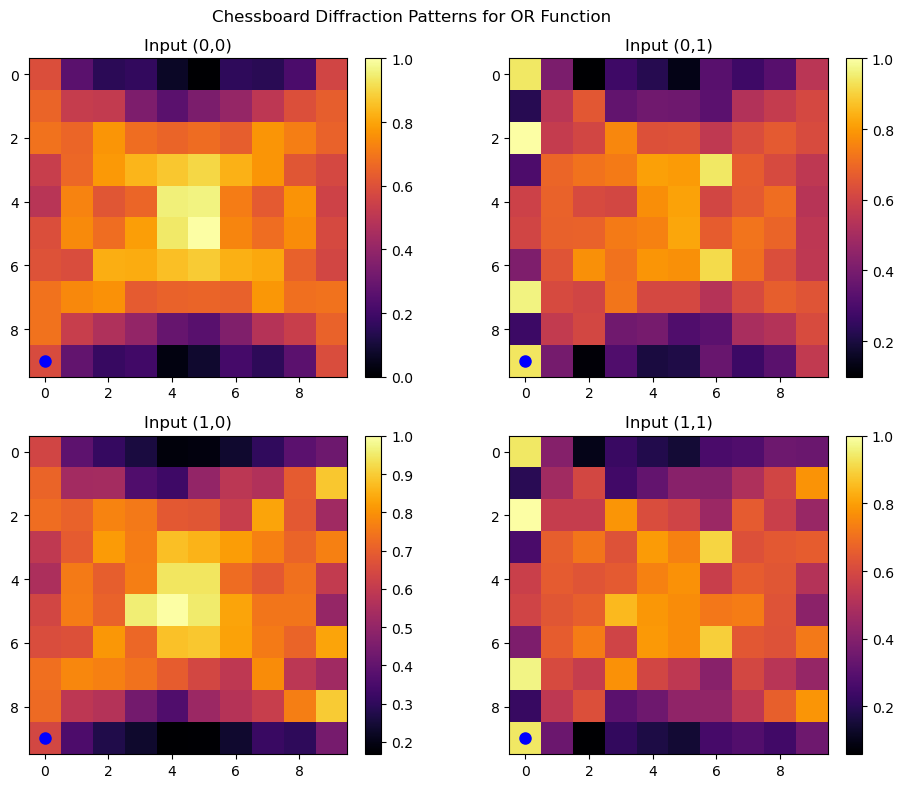

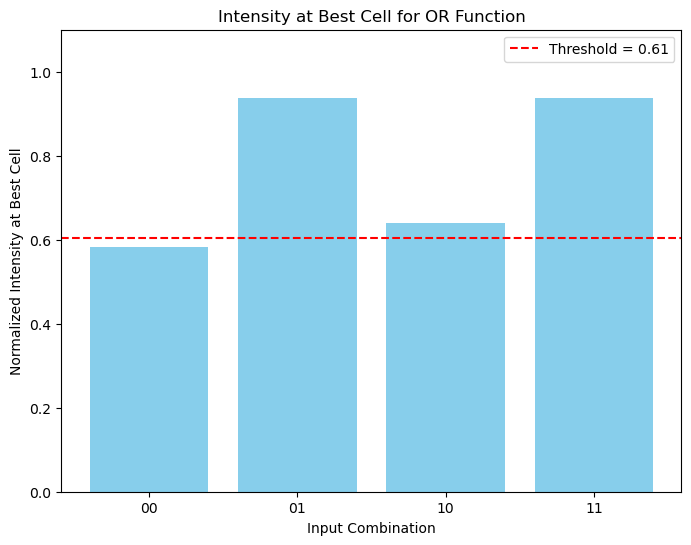

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def get_truth_table(logic_function):
    logic_function = logic_function.lower()
    if logic_function == 'and':
        return {(0, 0): 0, (0, 1): 0, (1, 0): 0, (1, 1): 1}
    elif logic_function == 'or':
        return {(0, 0): 0, (0, 1): 1, (1, 0): 1, (1, 1): 1}
    elif logic_function == 'xor':
        return {(0, 0): 0, (0, 1): 1, (1, 0): 1, (1, 1): 0}
    else:
        raise ValueError("Unsupported logic function! Choose AND, OR, or XOR")

def find_best_output_cell_for_logic(desired_truth_table, left_active, right_active):
    """
    Simulates the diffraction pattern for all four input combinations using the provided active input patterns,
    subtracts a background, normalizes the results, and scans the chessboard grid to find the cell that best matches
    the desired truth table. The error is measured as the sum of squared differences.
    """
    combinations = [(0, 0), (0, 1), (1, 0), (1, 1)]
    simulation_results = {}
    
    # Fixed simulation parameters.
    number_of_inputs = 9
    distance_between_inputs = 1440  # nm
    input_width = 240               # nm
    active_input_phase_shift = np.pi/2
    active_input_amplitude = 1      # unchanged
    wavelength = 232                # nm
    unit_cell_size = 15             # nm
    mid_line = 8000                 # nm
    w_axhl = 10
    x_size = 16000                  # nm
    n_on_chessboard = 10
    plots = False
    folding = False
    chess_plots = False

    # Simulate for each input combination.
    for left, right in combinations:
        # If the input is 1 use the candidate active pattern; otherwise, use an empty list.
        active_inputs_left = left_active if left == 1 else []
        active_inputs_right = right_active if right == 1 else []
        intensity_matrix = logic_oop(
            number_of_inputs,
            distance_between_inputs,  # nm
            input_width,  # nm
            active_inputs_left,
            active_inputs_right,
            active_input_phase_shift,
            active_input_amplitude,  # 1 -> unchanged
            wavelength,  # nm
            unit_cell_size,  # nm
            mid_line,  # nm
            w_axhl,
            x_size, #nm
            n_on_chessboard,
            plots,
            folding,
            chess_plots
            )
        simulation_results[(left, right)] = intensity_matrix

    # Use the (0,0) configuration to subtract a common background.
    background = np.min(simulation_results[(0, 0)])
    
    # Subtract background and normalize each simulation result.
    for key in simulation_results:
        intensity = simulation_results[key]
        intensity_corrected = intensity - background
        intensity_corrected = np.maximum(intensity_corrected, 0)
        simulation_results[key] = intensity_corrected / np.max(intensity_corrected)
    
    best_cell = None
    best_error = float('inf')
    n_rows, n_cols = simulation_results[(0, 0)].shape

    # Scan over all cells and compute the sum of squared errors relative to the desired truth table.
    for i in range(n_rows):
        for j in range(n_cols):
            total_error = 0.0
            for combo in combinations:
                value = simulation_results[combo][i, j]
                desired = desired_truth_table[combo]  # 0 or 1
                total_error += (value - desired)**2
            if total_error < best_error:
                best_error = total_error
                best_cell = (i, j)
    return best_cell, simulation_results

def verify_and_adjust_threshold(simulation_results, best_cell, desired_truth_table,
                                candidate_thresholds):
    """
    Iterates over candidate thresholds to check whether the output at best_cell matches the desired truth table.
    Returns the threshold that minimizes mismatches along with the mismatch count.
    """
    best_threshold = None
    best_mismatch = float('inf')
    for th in candidate_thresholds:
        mismatch = 0
        for combo, matrix in simulation_results.items():
            output = 1 if matrix[best_cell] > th else 0
            if output != desired_truth_table[combo]:
                mismatch += 1
        if mismatch == 0:
            return th, 0
        if mismatch < best_mismatch:
            best_mismatch = mismatch
            best_threshold = th
    return best_threshold, best_mismatch

def compute_quality(simulation_results, best_cell, threshold_value, desired_truth_table):
    """
    Computes a quality metric defined as the minimum absolute margin by which the normalized intensity at best_cell
    differs from the threshold.
    For each desired state, the margin is defined as |intensity - threshold|.
    Returns the minimum margin (a number between 0 and 1).
    """
    margins = []
    for combo, matrix in simulation_results.items():
        margin = abs(matrix[best_cell] - threshold_value)
        margins.append(margin)
    quality = min(margins)
    return quality

def plot_chessboard_results(simulation_results, best_cell, logic_function):
    """
    Creates a single figure with a 2×2 grid of subplots showing the normalized diffraction pattern for each input combination.
    The best_cell is marked on each subplot.
    """
    combos = [(0, 0), (0, 1), (1, 0), (1, 1)]
    titles = {(0, 0): "(0,0)", (0, 1): "(0,1)", (1, 0): "(1,0)", (1, 1): "(1,1)"}
    
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    for idx, combo in enumerate(combos):
        row = idx // 2
        col = idx % 2
        ax = axs[row, col]
        im = ax.imshow(simulation_results[combo], cmap='inferno')
        ax.set_title(f"Input {titles[combo]}")
        ax.plot(best_cell[1], best_cell[0], 'bo', markersize=8)
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.suptitle(f"Chessboard Diffraction Patterns for {logic_function.upper()} Function")
    plt.tight_layout()
    plt.show()

def plot_intensity_bar(simulation_results, best_cell, threshold_value, logic_function):
    """
    Plots a bar chart of the normalized intensity at best_cell for each input configuration.
    A horizontal line is drawn at the chosen threshold.
    """
    combos = [(0, 0), (0, 1), (1, 0), (1, 1)]
    intensity_values = []
    labels = []
    for combo in combos:
        intensity_values.append(simulation_results[combo][best_cell])
        labels.append(f"{combo[0]}{combo[1]}")
    
    fig, ax = plt.subplots(figsize=(8, 6))
    bars = ax.bar(labels, intensity_values, color='skyblue')
    ax.axhline(y=threshold_value, color='r', linestyle='--', label=f"Threshold = {threshold_value:.2f}")
    ax.set_ylim(0, 1.1)
    ax.set_xlabel("Input Combination")
    ax.set_ylabel("Normalized Intensity at Best Cell")
    ax.set_title(f"Intensity at Best Cell for {logic_function.upper()} Function")
    ax.legend()
    plt.show()

def run_logic_gate_simulation_for_logic(logic_function, required_quality=10):
    """
    Runs the simulation for the chosen logic function. It cycles through candidate active input combinations and thresholds,
    and returns the configuration (active inputs for left/right, threshold, best output cell, and quality)
    that exactly reproduces the desired truth table (zero mismatches) and meets the quality parameter.
    The parameter required_quality is given as a percentage (e.g. 10 means 10% difference, or 0.10 in normalized units).
    If no configuration gives an exact match with the required quality, it returns the best candidate.
    """
    desired_truth_table = get_truth_table(logic_function)
    candidate_thresholds = np.linspace(0.1, 0.9, 20)
    
    # Define candidate active input combinations.
    candidate_active_inputs_left = [
        [1, 3, 5, 7, 9],
        [1, 5, 9],
        [3, 7],
        [1, 3, 5],
        [3, 5, 7]
    ]
    candidate_active_inputs_right = [
        [0, 2, 4, 6, 8],
        [0, 4, 8],
        [2, 6],
        [0, 2, 4],
        [4, 6, 8]
    ]
    
    best_configuration = None
    best_overall_mismatch = float('inf')
    best_overall_quality = -float('inf')
    
    req_quality_value = required_quality / 100.0  # convert percentage to normalized value
    
    # Try all candidate combinations.
    for left_active in candidate_active_inputs_left:
        for right_active in candidate_active_inputs_right:
            print(f"Trying left inputs: {left_active} and right inputs: {right_active}")
            best_cell, simulation_results = find_best_output_cell_for_logic(desired_truth_table, left_active, right_active)
            threshold_value, mismatch_count = verify_and_adjust_threshold(simulation_results, best_cell,
                                                                          desired_truth_table, candidate_thresholds)
            quality = compute_quality(simulation_results, best_cell, threshold_value, desired_truth_table)
            print(f"  With threshold {threshold_value:.2f}, mismatch count = {mismatch_count}, quality = {quality:.2f}")
            # Check if configuration is acceptable: zero mismatches and quality meets requirement.
            if mismatch_count == 0 and quality >= req_quality_value:
                print("Found configuration with zero mismatches and required quality!")
                best_configuration = {
                    'left_active': left_active,
                    'right_active': right_active,
                    'threshold': threshold_value,
                    'best_cell': best_cell,
                    'simulation_results': simulation_results,
                    'mismatch_count': mismatch_count,
                    'quality': quality
                }
                # Return immediately if an exact match with acceptable quality is found.
                break
            # Otherwise, update best candidate (prefer lower mismatch; for equal mismatches, prefer higher quality)
            elif (mismatch_count < best_overall_mismatch) or \
                 (mismatch_count == best_overall_mismatch and quality > best_overall_quality):
                best_overall_mismatch = mismatch_count
                best_overall_quality = quality
                best_configuration = {
                    'left_active': left_active,
                    'right_active': right_active,
                    'threshold': threshold_value,
                    'best_cell': best_cell,
                    'simulation_results': simulation_results,
                    'mismatch_count': mismatch_count,
                    'quality': quality
                }
        if best_configuration is not None and best_configuration['mismatch_count'] == 0 and best_configuration['quality'] >= req_quality_value:
            break

    # Report the found configuration.
    print("Final chosen parameters:")
    print("  Left active inputs:", best_configuration['left_active'])
    print("  Right active inputs:", best_configuration['right_active'])
    print("  Best output cell:", best_configuration['best_cell'])
    print("  Threshold selected:", best_configuration['threshold'])
    print("  Quality achieved:", best_configuration['quality'])
    if best_configuration['mismatch_count'] != 0:
        print(f"Warning: The desired truth table was not exactly achieved (mismatch count = {best_configuration['mismatch_count']}).")
    if best_configuration['quality'] < req_quality_value:
        print(f"Warning: The achieved quality ({best_configuration['quality']:.2f}) is below the required threshold ({req_quality_value:.2f}).")
    
    # Generate the truth table.
    truth_table = {}
    for inputs, norm_intensity_matrix in best_configuration['simulation_results'].items():
        logic_value = 1 if norm_intensity_matrix[best_configuration['best_cell']] > best_configuration['threshold'] else 0
        truth_table[inputs] = logic_value
        print(f"Inputs {inputs} -> Output at cell {best_configuration['best_cell']}: {logic_value}")
    
    return truth_table, best_configuration

if __name__ == "__main__":
    # Let the user choose the logic function and required quality.
    logic_function = input("Enter logic function (AND, OR, XOR): ")
    try:
        required_quality = float(input("Enter required quality in percent (e.g., 10 for 10%): "))
    except:
        required_quality = 10.0  # default to 10%
    
    truth_table, config = run_logic_gate_simulation_for_logic(logic_function, required_quality)
    print("Generated Truth Table:", truth_table)
    
    # Create a matrix of subplots showing the diffraction patterns.
    plot_chessboard_results(config['simulation_results'], config['best_cell'], logic_function)
    
    # Plot the normalized intensity at the best cell for each truth table state, including the threshold line.
    plot_intensity_bar(config['simulation_results'], config['best_cell'], config['threshold'], logic_function)